### This Notebook is identical to the Logistic_Regression-week1-PART_A-EMC-GEFS. The only thing that changes is that at the beginning I select week2 lead times

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime

from datetime import timedelta, datetime, date
import calendar

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import glob

In [2]:
ds_allpr = xr.open_dataset('ds_pr_t_td_cape_EMCB.nc')

# LOGISTIC REGRESSION

# SELECT LEAD TIMES


Looking at week 2

In [3]:
#week 1
week1lr_all = ds_allpr.sel(L=slice(8.5,14.5)) 
#I drop the first value, L=0.5, 
#I stack only M and lat and lon
week1lr_all = week1lr_all.stack(Mll=('M','lat','lon')).compute()
week1lr_all = week1lr_all.rename({'APCP_P1_L1_GLL0':'pr','TMP_P1_L103_GLL0':'tas', 
                'DPT_P1_L103_GLL0':'tdps','CAPE_P1_2L108_GLL0':'cape'})
week1lr_all

/local/ERAin/lib/python3.6/site-packages/xarray/core/dataset.py:2648: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  v.labels,


<xarray.Dataset>
Dimensions:  (L: 7, Mll: 1694, S: 131)
Coordinates:
  * L        (L) float64 8.5 9.5 10.5 11.5 12.5 13.5 14.5
  * S        (S) datetime64[ns] 1999-06-02 1999-06-09 ... 2008-08-20 2008-08-27
  * Mll      (Mll) MultiIndex
  - M        (Mll) int64 0 0 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 10 10 10
  - lat      (Mll) float64 42.0 42.0 42.0 42.0 42.0 ... 32.0 32.0 32.0 32.0 32.0
  - lon      (Mll) float64 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
Data variables:
    pr       (S, L, Mll) float32 26.6 9.3 1.0 2.4 6.1 ... 0.1 0.6 12.0 12.1 11.5
    tas      (S, L, Mll) float32 295.30002 295.2 296.2 ... 299.7 299.0 298.0
    tdps     (S, L, Mll) float32 291.30002 291.30002 291.2 ... 293.30002 292.9
    cape     (S, L, Mll) float32 2238.0 2181.0 1832.0 ... 855.0 747.0 613.0

In [4]:
# I average along L, it means that i am using the average value for week1
week1lr = week1lr_all.mean(dim='L')
week1lr

<xarray.Dataset>
Dimensions:  (Mll: 1694, S: 131)
Coordinates:
  * S        (S) datetime64[ns] 1999-06-02 1999-06-09 ... 2008-08-20 2008-08-27
  * Mll      (Mll) MultiIndex
  - M        (Mll) int64 0 0 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 10 10 10
  - lat      (Mll) float64 42.0 42.0 42.0 42.0 42.0 ... 32.0 32.0 32.0 32.0 32.0
  - lon      (Mll) float64 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
Data variables:
    pr       (S, Mll) float32 5.3 2.9142857 1.7714285 ... 1.8142859 1.9857142
    tas      (S, Mll) float32 297.3143 297.37143 ... 297.30002 296.30002
    tdps     (S, Mll) float32 286.2143 287.68573 289.1143 ... 290.4286 290.3143
    cape     (S, Mll) float32 1328.2858 1557.2858 1645.8572 ... 185.0 173.57143

# Here I calculate the (first) target time for each weekly average. 
# I add a 12 hour to use the center value as in INGRID, but really it starts at 00z

# to be honest i don't recall why I made this choice. We can change the value, it wouldn't change the results a lot, since the whole vector T would translate of the same amount (I think)

In [5]:
# here I calculate T, in the case of week 2 the first T values is S+8.5
week1lr.coords['T']= (('S'), week1lr['S'].values+np.timedelta64(8,'D')+np.timedelta64(12,'h'))

week1lr


<xarray.Dataset>
Dimensions:  (Mll: 1694, S: 131)
Coordinates:
  * S        (S) datetime64[ns] 1999-06-02 1999-06-09 ... 2008-08-20 2008-08-27
  * Mll      (Mll) MultiIndex
  - M        (Mll) int64 0 0 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 10 10 10
  - lat      (Mll) float64 42.0 42.0 42.0 42.0 42.0 ... 32.0 32.0 32.0 32.0 32.0
  - lon      (Mll) float64 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
    T        (S) datetime64[ns] 1999-06-10T12:00:00 ... 2008-09-04T12:00:00
Data variables:
    pr       (S, Mll) float32 5.3 2.9142857 1.7714285 ... 1.8142859 1.9857142
    tas      (S, Mll) float32 297.3143 297.37143 ... 297.30002 296.30002
    tdps     (S, Mll) float32 286.2143 287.68573 289.1143 ... 290.4286 290.3143
    cape     (S, Mll) float32 1328.2858 1557.2858 1645.8572 ... 185.0 173.57143

# GET NARR

## I select the weekly averages from NARR for the same period.


In [6]:
import netCDF4
ds_Y =[]
for iy in np.arange(1999, 2009):#2017):
    print( iy)
    url = ('http://iridl.ldeo.columbia.edu/expert/home/.clepore/.NARR_ESRL_3hr_CONUS_1x1/.apcp/time/('+
           np.str(iy)+
          ')/VALUES/time/(0000%201%20Jun)/(0000%2011%20Oct)/RANGE/lat/32/42/RANGE/lon/257/270/RANGE/time/1/boxAverage/time/7/runningAverage/')
    print(url)
    ds_temp = xr.open_dataset(url+'dods')
    ds_Y.append(ds_temp)
    del ds_temp
    
ds_NARRpr = xr.concat(ds_Y, dim='time')

1999
http://iridl.ldeo.columbia.edu/expert/home/.clepore/.NARR_ESRL_3hr_CONUS_1x1/.apcp/time/(1999)/VALUES/time/(0000%201%20Jun)/(0000%2011%20Oct)/RANGE/lat/32/42/RANGE/lon/257/270/RANGE/time/1/boxAverage/time/7/runningAverage/
2000
http://iridl.ldeo.columbia.edu/expert/home/.clepore/.NARR_ESRL_3hr_CONUS_1x1/.apcp/time/(2000)/VALUES/time/(0000%201%20Jun)/(0000%2011%20Oct)/RANGE/lat/32/42/RANGE/lon/257/270/RANGE/time/1/boxAverage/time/7/runningAverage/
2001
http://iridl.ldeo.columbia.edu/expert/home/.clepore/.NARR_ESRL_3hr_CONUS_1x1/.apcp/time/(2001)/VALUES/time/(0000%201%20Jun)/(0000%2011%20Oct)/RANGE/lat/32/42/RANGE/lon/257/270/RANGE/time/1/boxAverage/time/7/runningAverage/
2002
http://iridl.ldeo.columbia.edu/expert/home/.clepore/.NARR_ESRL_3hr_CONUS_1x1/.apcp/time/(2002)/VALUES/time/(0000%201%20Jun)/(0000%2011%20Oct)/RANGE/lat/32/42/RANGE/lon/257/270/RANGE/time/1/boxAverage/time/7/runningAverage/
2003
http://iridl.ldeo.columbia.edu/expert/home/.clepore/.NARR_ESRL_3hr_CONUS_1x1/.apcp/

In [7]:
ds_NARRpr

<xarray.Dataset>
Dimensions:  (lat: 11, lon: 14, time: 1260)
Coordinates:
  * lat      (lat) float32 32.0 33.0 34.0 35.0 36.0 ... 38.0 39.0 40.0 41.0 42.0
  * lon      (lon) float32 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
  * time     (time) datetime64[ns] 1999-06-04T12:00:00 ... 2008-10-07T12:00:00
Data variables:
    apcp     (time, lat, lon) float32 0.029748198 0.17702778 ... 0.42098477
Attributes:
    Conventions:  IRIDL

## INGRID gives the center of the week as time index - so the first value (1-8) has date 4.5.
## I will fix that to match my time index.

## This needs to be done similarly for week2 when the range of L is for 8-14.


In [8]:
ds_NARRpr.coords['time'] = ds_NARRpr.time-np.timedelta64(3,'D')

# I then select the weeks that correspond to week1 forecasts.

In [9]:
ds_NARRpr_T = ds_NARRpr.sel(time=week1lr["T"])
ds_NARRpr_T

<xarray.Dataset>
Dimensions:  (S: 131, lat: 11, lon: 14)
Coordinates:
  * lat      (lat) float32 32.0 33.0 34.0 35.0 36.0 ... 38.0 39.0 40.0 41.0 42.0
  * lon      (lon) float32 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
    time     (S) datetime64[ns] 1999-06-10T12:00:00 ... 2008-09-04T12:00:00
  * S        (S) datetime64[ns] 1999-06-02 1999-06-09 ... 2008-08-20 2008-08-27
    T        (S) datetime64[ns] 1999-06-10T12:00:00 ... 2008-09-04T12:00:00
Data variables:
    apcp     (S, lat, lon) float32 0.17986739 0.49238753 ... 0.6004455 0.7073687
Attributes:
    Conventions:  IRIDL

Because of the selection of the dates, now in the coordinates i have a few time coordinates:
    - time is == T and it is now a function of (S) because T(S)
    - I have S and T(S) that come from week1lr
    
To make it look like my forecast data, I will drop time

In [10]:
ds_NARRpr_T = ds_NARRpr_T.drop('time')

# However, the results I have are a function of the target time (or period, in this case a week, which I indexed with the first day of the week). 

# So I will swap dimension so that my data are all a function of T and Mll

In [11]:
week1lr

<xarray.Dataset>
Dimensions:  (Mll: 1694, S: 131)
Coordinates:
  * S        (S) datetime64[ns] 1999-06-02 1999-06-09 ... 2008-08-20 2008-08-27
  * Mll      (Mll) MultiIndex
  - M        (Mll) int64 0 0 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 10 10 10
  - lat      (Mll) float64 42.0 42.0 42.0 42.0 42.0 ... 32.0 32.0 32.0 32.0 32.0
  - lon      (Mll) float64 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
    T        (S) datetime64[ns] 1999-06-10T12:00:00 ... 2008-09-04T12:00:00
Data variables:
    pr       (S, Mll) float32 5.3 2.9142857 1.7714285 ... 1.8142859 1.9857142
    tas      (S, Mll) float32 297.3143 297.37143 ... 297.30002 296.30002
    tdps     (S, Mll) float32 286.2143 287.68573 289.1143 ... 290.4286 290.3143
    cape     (S, Mll) float32 1328.2858 1557.2858 1645.8572 ... 185.0 173.57143

In [12]:
week1lr = week1lr.swap_dims({'S':'T'})
week1lr

<xarray.Dataset>
Dimensions:  (Mll: 1694, T: 131)
Coordinates:
    S        (T) datetime64[ns] 1999-06-02 1999-06-09 ... 2008-08-20 2008-08-27
  * Mll      (Mll) MultiIndex
  - M        (Mll) int64 0 0 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 10 10 10
  - lat      (Mll) float64 42.0 42.0 42.0 42.0 42.0 ... 32.0 32.0 32.0 32.0 32.0
  - lon      (Mll) float64 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
  * T        (T) datetime64[ns] 1999-06-10T12:00:00 ... 2008-09-04T12:00:00
Data variables:
    pr       (T, Mll) float32 5.3 2.9142857 1.7714285 ... 1.8142859 1.9857142
    tas      (T, Mll) float32 297.3143 297.37143 ... 297.30002 296.30002
    tdps     (T, Mll) float32 286.2143 287.68573 289.1143 ... 290.4286 290.3143
    cape     (T, Mll) float32 1328.2858 1557.2858 1645.8572 ... 185.0 173.57143

In [13]:
ds_NARRpr_T

<xarray.Dataset>
Dimensions:  (S: 131, lat: 11, lon: 14)
Coordinates:
  * lat      (lat) float32 32.0 33.0 34.0 35.0 36.0 ... 38.0 39.0 40.0 41.0 42.0
  * lon      (lon) float32 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
  * S        (S) datetime64[ns] 1999-06-02 1999-06-09 ... 2008-08-20 2008-08-27
    T        (S) datetime64[ns] 1999-06-10T12:00:00 ... 2008-09-04T12:00:00
Data variables:
    apcp     (S, lat, lon) float32 0.17986739 0.49238753 ... 0.6004455 0.7073687
Attributes:
    Conventions:  IRIDL

In [14]:
ds_NARRpr_T = ds_NARRpr_T.swap_dims({'S':'T'})
ds_NARRpr_T


<xarray.Dataset>
Dimensions:  (T: 131, lat: 11, lon: 14)
Coordinates:
  * lat      (lat) float32 32.0 33.0 34.0 35.0 36.0 ... 38.0 39.0 40.0 41.0 42.0
  * lon      (lon) float32 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
    S        (T) datetime64[ns] 1999-06-02 1999-06-09 ... 2008-08-20 2008-08-27
  * T        (T) datetime64[ns] 1999-06-10T12:00:00 ... 2008-09-04T12:00:00
Data variables:
    apcp     (T, lat, lon) float32 0.17986739 0.49238753 ... 0.6004455 0.7073687
Attributes:
    Conventions:  IRIDL

(0.05, 0.45)

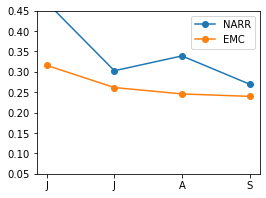

In [15]:
#quick compariosn for monthly averages
fig = plt.figure(figsize=(4,3))
plt.plot(ds_NARRpr_T.apcp.mean(dim=['lat','lon']).groupby('T.month').mean(),'-o')
plt.plot(week1lr.mean(dim='Mll').pr.groupby('T.month').mean()/8,'-o') 
plt.legend(('NARR','EMC'))
plt.xticks((0,1,2,3),('J','J','A','S'))
plt.ylim((0.05,0.45))

Text(0.9, 0.9, 'corr=0.39')

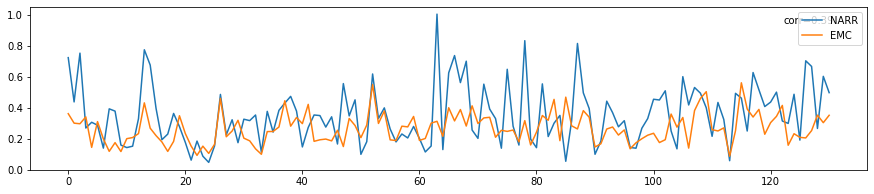

In [16]:
# quick comparison for weekly averages
fig = plt.figure(figsize=(15,3))
ax = plt.subplot(111)
plt.plot(ds_NARRpr_T.apcp.mean(dim=['lat','lon']))
plt.plot(week1lr.mean(dim='Mll').pr/8) 
plt.legend(('NARR','EMC'))
plt.text(0.9,0.9,
         'corr='+np.str(np.round(np.corrcoef(ds_NARRpr_T.apcp.mean(dim=['lat','lon']),week1lr.mean(dim='Mll').pr/8)[0,1],
                  2, )),transform=ax.transAxes)

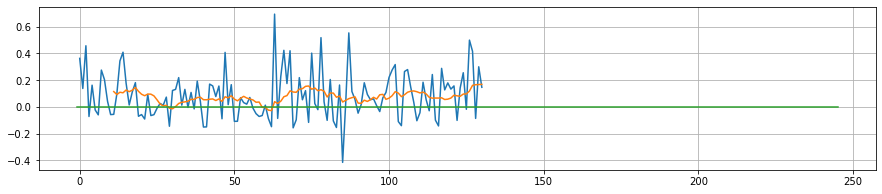

In [17]:
# calculate differences and a rolling mean.
fig = plt.figure(figsize=(15,3))

differences = (ds_NARRpr_T.apcp.mean(dim=['lat','lon']))-(week1lr.mean(dim='Mll').pr/8)
plt.plot(differences)
plt.plot((differences.rolling(T=12).mean().values))

plt.plot([-1,245],[0,0])
plt.grid()

Text(0, 0.5, 'EMC')

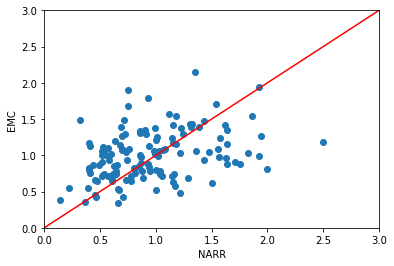

In [18]:
# compare quantiles over the area
plt.plot(ds_NARRpr_T.apcp.quantile(q=0.95,dim=['lat','lon']),
         week1lr.quantile(q=0.95,dim='Mll').pr/8,'o') 
plt.xlim((0,3))
plt.ylim((0,3))
plt.plot([0,3],[0,3],'r-')
plt.xlabel('NARR')
plt.ylabel('EMC')

Text(0, 0.5, 'EMC')

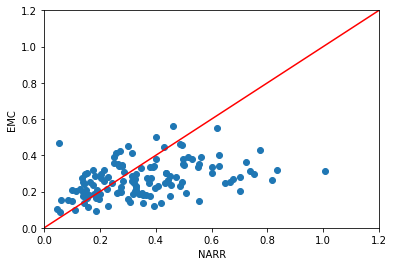

In [19]:
# calculate the mean over the investigated area.
plt.plot(ds_NARRpr_T.apcp.mean(dim=['lat','lon']),week1lr.mean(dim='Mll').pr/8,'o') 
plt.xlim((0,1.2))
plt.ylim((0,1.2))
plt.plot([0,1.5],[0,1.5],'r-')
plt.xlabel('NARR')
plt.ylabel('EMC')

# Save the data for next step

In [20]:
week1lr

<xarray.Dataset>
Dimensions:  (Mll: 1694, T: 131)
Coordinates:
    S        (T) datetime64[ns] 1999-06-02 1999-06-09 ... 2008-08-20 2008-08-27
  * Mll      (Mll) MultiIndex
  - M        (Mll) int64 0 0 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 10 10 10
  - lat      (Mll) float64 42.0 42.0 42.0 42.0 42.0 ... 32.0 32.0 32.0 32.0 32.0
  - lon      (Mll) float64 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
  * T        (T) datetime64[ns] 1999-06-10T12:00:00 ... 2008-09-04T12:00:00
Data variables:
    pr       (T, Mll) float32 5.3 2.9142857 1.7714285 ... 1.8142859 1.9857142
    tas      (T, Mll) float32 297.3143 297.37143 ... 297.30002 296.30002
    tdps     (T, Mll) float32 286.2143 287.68573 289.1143 ... 290.4286 290.3143
    cape     (T, Mll) float32 1328.2858 1557.2858 1645.8572 ... 185.0 173.57143

In [21]:
ds_NARRpr_T

<xarray.Dataset>
Dimensions:  (T: 131, lat: 11, lon: 14)
Coordinates:
  * lat      (lat) float32 32.0 33.0 34.0 35.0 36.0 ... 38.0 39.0 40.0 41.0 42.0
  * lon      (lon) float32 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
    S        (T) datetime64[ns] 1999-06-02 1999-06-09 ... 2008-08-20 2008-08-27
  * T        (T) datetime64[ns] 1999-06-10T12:00:00 ... 2008-09-04T12:00:00
Data variables:
    apcp     (T, lat, lon) float32 0.17986739 0.49238753 ... 0.6004455 0.7073687
Attributes:
    Conventions:  IRIDL

In [22]:
week1lr = week1lr.unstack()

In [23]:
ds_merged = xr.merge([ds_NARRpr_T ,week1lr])
ds_merged

<xarray.Dataset>
Dimensions:  (M: 11, T: 131, lat: 11, lon: 14)
Coordinates:
  * lat      (lat) float64 32.0 33.0 34.0 35.0 36.0 ... 38.0 39.0 40.0 41.0 42.0
  * lon      (lon) float32 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
    S        (T) datetime64[ns] 1999-06-02 1999-06-09 ... 2008-08-20 2008-08-27
  * T        (T) datetime64[ns] 1999-06-10T12:00:00 ... 2008-09-04T12:00:00
  * M        (M) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    apcp     (T, lat, lon) float32 0.17986739 0.49238753 ... 0.6004455 0.7073687
    pr       (T, M, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tas      (T, M, lat, lon) float32 305.17142 304.35715 ... 297.22858
    tdps     (T, M, lat, lon) float32 281.95712 283.9 ... 283.65717 281.94284
    cape     (T, M, lat, lon) float32 135.42857 183.14285 ... 183.57143 153.0

# Note how apcp is of course missing the M dimension (ensemble member)

In [24]:
ds_merged.to_netcdf('ds_merged_EMC_allM_week2.nc')

# we could broadcast NARR dimensions (T, lat, lon) to (T,M,lat,lon), but we won't do it now, I don't think we need it.
